/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4


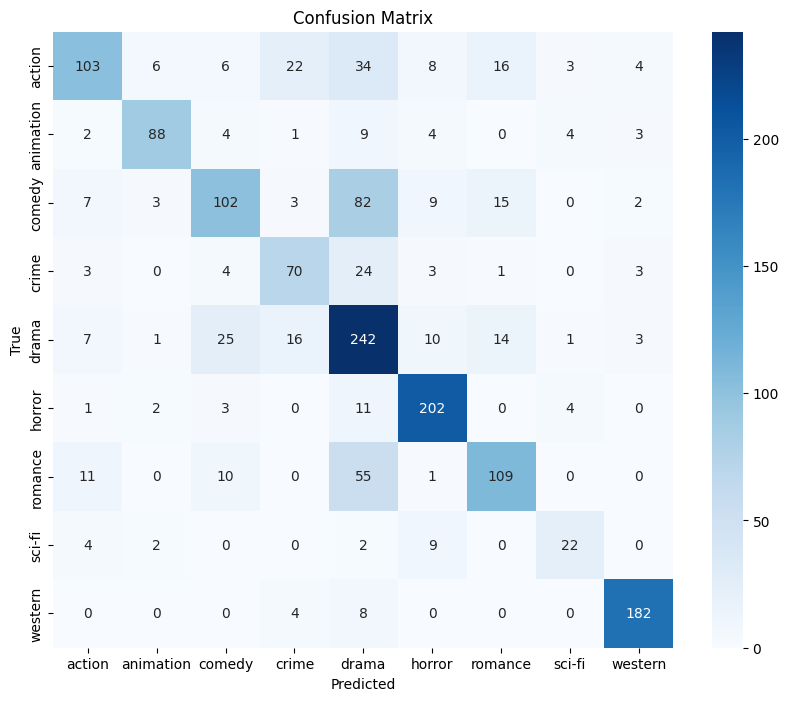

Validation Accuracy: 0.6961
              precision    recall  f1-score   support

      action       0.75      0.51      0.61       202
   animation       0.86      0.77      0.81       115
      comedy       0.66      0.46      0.54       223
       crime       0.60      0.65      0.62       108
       drama       0.52      0.76      0.62       319
      horror       0.82      0.91      0.86       223
     romance       0.70      0.59      0.64       186
      sci-fi       0.65      0.56      0.60        39
     western       0.92      0.94      0.93       194

    accuracy                           0.70      1609
   macro avg       0.72      0.68      0.69      1609
weighted avg       0.71      0.70      0.69      1609

Epoch 2/4


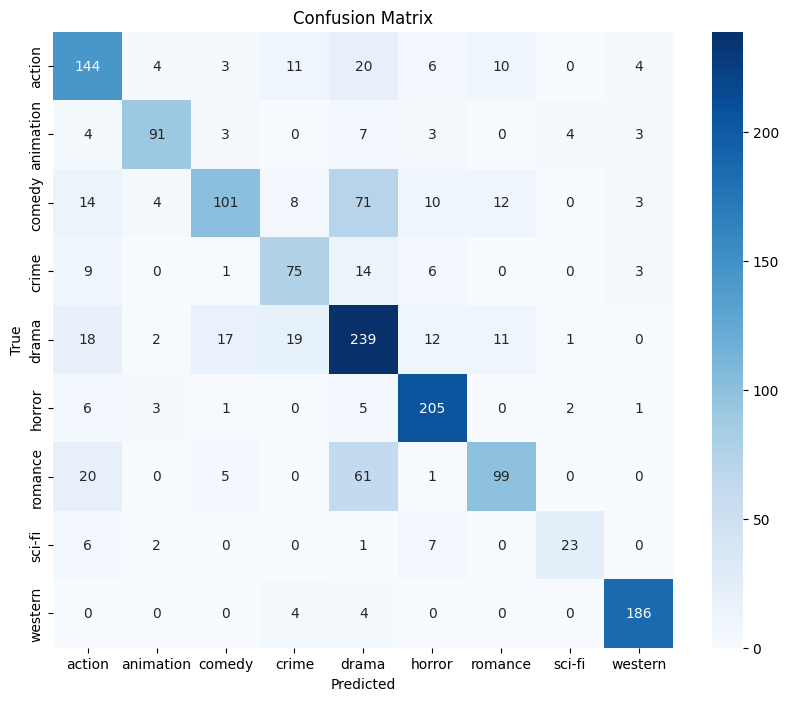

Validation Accuracy: 0.7228
              precision    recall  f1-score   support

      action       0.65      0.71      0.68       202
   animation       0.86      0.79      0.82       115
      comedy       0.77      0.45      0.57       223
       crime       0.64      0.69      0.67       108
       drama       0.57      0.75      0.65       319
      horror       0.82      0.92      0.87       223
     romance       0.75      0.53      0.62       186
      sci-fi       0.77      0.59      0.67        39
     western       0.93      0.96      0.94       194

    accuracy                           0.72      1609
   macro avg       0.75      0.71      0.72      1609
weighted avg       0.74      0.72      0.72      1609

Epoch 3/4


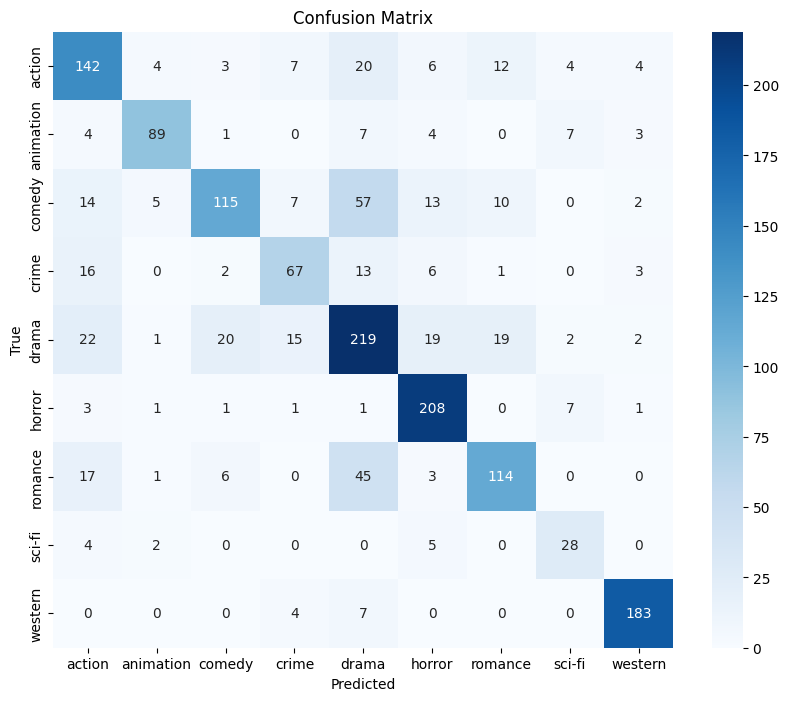

Validation Accuracy: 0.7241
              precision    recall  f1-score   support

      action       0.64      0.70      0.67       202
   animation       0.86      0.77      0.82       115
      comedy       0.78      0.52      0.62       223
       crime       0.66      0.62      0.64       108
       drama       0.59      0.69      0.64       319
      horror       0.79      0.93      0.85       223
     romance       0.73      0.61      0.67       186
      sci-fi       0.58      0.72      0.64        39
     western       0.92      0.94      0.93       194

    accuracy                           0.72      1609
   macro avg       0.73      0.72      0.72      1609
weighted avg       0.73      0.72      0.72      1609

Epoch 4/4


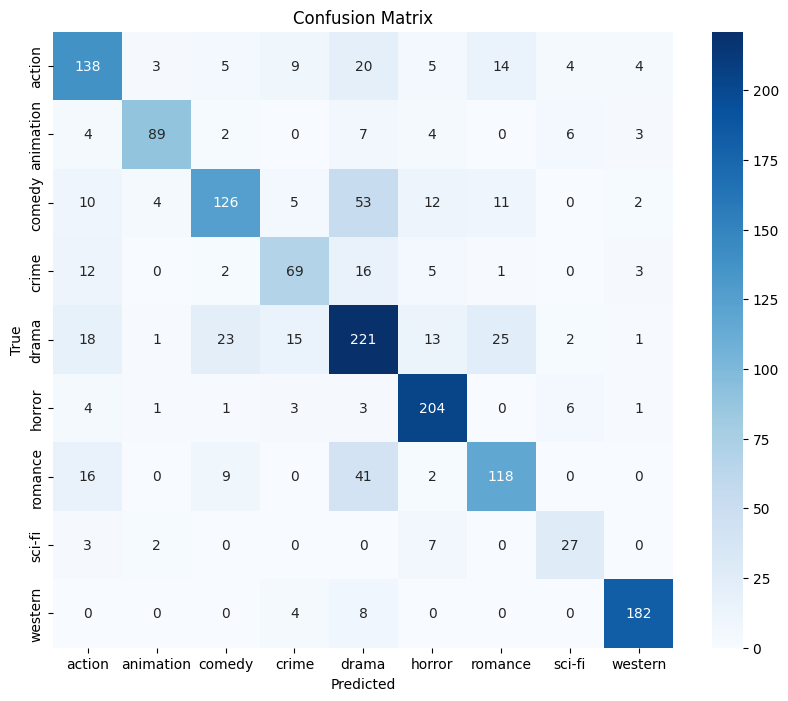

Validation Accuracy: 0.7296
              precision    recall  f1-score   support

      action       0.67      0.68      0.68       202
   animation       0.89      0.77      0.83       115
      comedy       0.75      0.57      0.64       223
       crime       0.66      0.64      0.65       108
       drama       0.60      0.69      0.64       319
      horror       0.81      0.91      0.86       223
     romance       0.70      0.63      0.66       186
      sci-fi       0.60      0.69      0.64        39
     western       0.93      0.94      0.93       194

    accuracy                           0.73      1609
   macro avg       0.73      0.73      0.73      1609
weighted avg       0.73      0.73      0.73      1609



In [ ]:
import os
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaTokenizer, RobertaModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Set random seed in order to have reproduceable results
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

set_seed(42)

# Preprocess
def load_movie_data(data_file):
    df = pd.read_csv(data_file, sep='\t', header=None, names=['title', 'origin', 'genre', 'director', 'plot'])
    texts = df['plot'].tolist()  # Use movie plots for classification
    labels = df['genre'].tolist()  # Use genres as labels
    return texts, labels

data_file = 'train.txt'
texts, labels = load_movie_data(data_file)

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)  # Convert genres to numeric labels


class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Class to define the imported RoBERTa model.
class RoBERTaClassifier(nn.Module):
    def __init__(self, roberta_model_name, num_classes):
        super(RoBERTaClassifier, self).__init__()
        self.roberta = RobertaModel.from_pretrained(roberta_model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.roberta.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits

# Function to train the model.
def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

# Function to evaluate the model's performance at each step of its training.
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())


    accuracy = accuracy_score(actual_labels, predictions)

    report = classification_report(actual_labels, predictions, target_names=label_encoder.classes_)

    cm = confusion_matrix(actual_labels, predictions)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, report, predictions

#Model parameters
roberta_model_name = 'roberta-base'
num_classes = len(label_encoder.classes_)
max_length = 512
batch_size = 16
num_epochs = 4
learning_rate = 2e-5

train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

tokenizer = RobertaTokenizer.from_pretrained(roberta_model_name)
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

# Set up the device and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RoBERTaClassifier(roberta_model_name, num_classes).to(device)

# Set up the optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Run the training epochs and print evaluation results to analyze the model's performance
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train(model, train_dataloader, optimizer, scheduler, device)
    accuracy, report, predictions = evaluate(model, val_dataloader, device)
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(report)

In [ ]:
# Load the 'test_no_labels.txt' plots in order to classify their genres with the trained model.

def load_test_data(data_file):
    df = pd.read_csv(data_file, sep='\t', header=None, names=['title', 'origin', 'director', 'plot'])
    texts = df['plot'].tolist()  # Only use the plots for prediction
    return texts, df

test_data_file = 'test_no_labels.txt'
test_texts, test_df = load_test_data(test_data_file)

# Class to process the plots text.
class TestTextDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
        }

# Prediction of the genres
def predict(model, data_loader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())

    return predictions


test_dataset = TestTextDataset(test_texts, tokenizer, max_length)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)


predicted_labels = predict(model, test_dataloader, device)

predicted_genres = label_encoder.inverse_transform(predicted_labels)

test_df['predicted_genre'] = predicted_genres

print(test_df[['predicted_genre']].head())

# Obtaining the 'results.txt' output.
test_df[['predicted_genre']].to_csv('results.txt', index=False, header=False)